# Segmentación (SAM y GeoAI)

## Caso de Estudio: Entrenar un modelo de detección de cubiertas en Guasca

En este caso de estudio se utilizará la herramienta **GeoAI** para la detección de cubiertas en el municipio de **Guasca**, empleando la red neuronal **Mask R-CNN**. Este enfoque combina el análisis geoespacial con técnicas avanzadas de visión por computador para identificar y segmentar cubiertas en imágenes satelitales.


### Geoai

[GeoAI](https://geoai.gishub.org) es un proyecto de código abierto que integra inteligencia artificial con análisis geoespacial en Python. Permite visualizar, procesar, segmentar y clasificar datos satelitales y vectoriales usando modelos como Segment Anything y técnicas de *deep learning*.

Es liderado por el **GeoAI Lab** de la **University of Tennessee, Knoxville**, bajo la dirección del Dr. **Qiusheng Wu**, experto en SIG y análisis geoespacial con Python.

In [1]:
%pip install geoai-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.7/618.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import zipfile
import os
import geoai
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [3]:
%%capture
!wget https://github.com/Luisafrodriguezo1/Diplomado_PDI/raw/refs/heads/main/D2M1_4_redes_convolucionales/Guasca.zip


In [4]:
zip_path = "Guasca.zip"
extract_folder = "/content"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [23]:
train_raster_path = "/content/Guasca/Orto_guasca_train.tif"
train_vector_path = "/content/Guasca/train_guasca.shp"
test_raster_path = "/content/Guasca/Orto_guasca_test.tif"

In [6]:
def graficar_mascara_sobre_raster(train_vector_path: str, test_raster_path: str):
    """
    Grafica un shapefile (vector) sobre un ráster.

    :param train_vector_path: Ruta del archivo shapefile (.shp).
    :param test_raster_path: Ruta del archivo ráster (.tif).
    """
    try:
        # Leer el archivo ráster
        with rasterio .open(test_raster_path) as src:
            # Crear figura y ejes
            fig, ax = plt.subplots(figsize=(10, 10))

            # Mostrar el ráster en los ejes
            # Usamos `show` de rasterio para manejar la georreferenciación
            show(src, ax=ax, cmap='gray', title="Shapefile sobre Ráster")

            #  Leer el archivo shapefile
            vector_data = gpd.read_file(train_vector_path)

            # Verificar y transformar CRS si es necesario (opcional pero recomendado)
            if vector_data.crs != src.crs:
                print(f"Transformando CRS del vector de {vector_data.crs} a {src.crs}...")
                vector_data = vector_data.to_crs(src.crs)

            # Graficar el shapefile sobre el ráster
            # Trazamos solo el límite (`boundary`) para que no oculte el ráster
            # `ax=ax` asegura que se trace en el mismo gráfico
            vector_data.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

            # Opcional: Agregar título y mostrar el gráfico
            plt.xlabel("Coordenada X")
            plt.ylabel("Coordenada Y")
            plt.show()

    except rio.RasterioIOError:
        print(f"Error: No se pudo abrir el archivo ráster en la ruta: {test_raster_path}")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

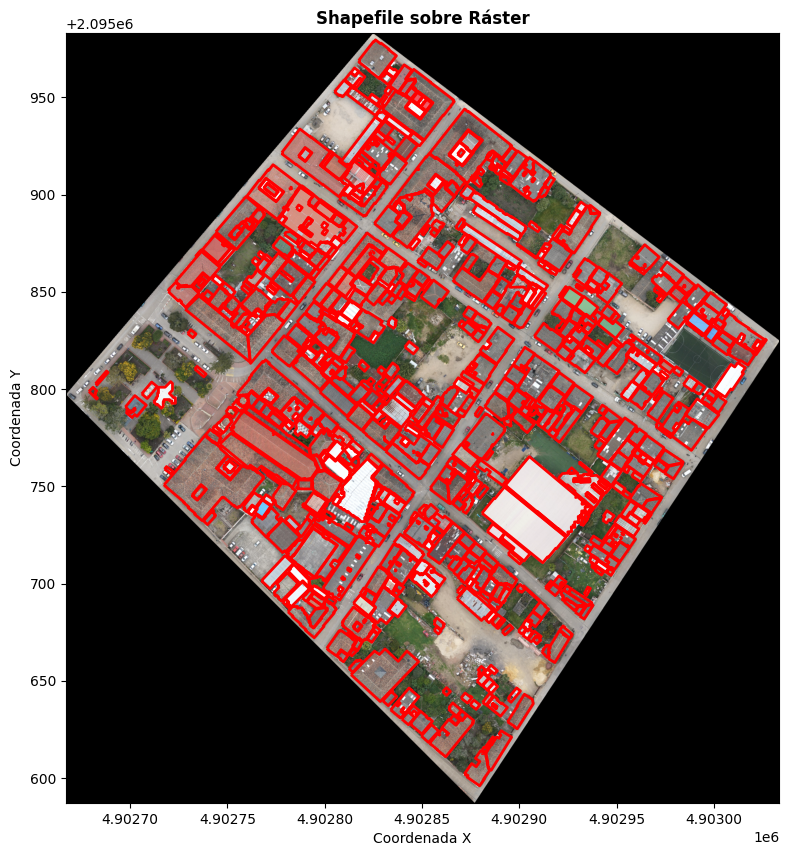

In [7]:
graficar_mascara_sobre_raster(train_vector_path, train_raster_path)


La función `geoai.export_geotiff_tiles()` para preparar los datos de entrenamiento para un modelo de aprendizaje profundo

Esta función corta el raster de entrada (`train_raster_path`) en mosaicos pequeños (o *tiles*) junto con sus respectivas etiquetas derivadas del vector (`train_vector_path`), de la siguiente manera:

- **`in_raster`**: ruta al raster de entrada.
- **`out_folder`**: carpeta de salida donde se guardarán los tiles generados.
- **`in_class_data`**: ruta al archivo vectorial con las clases (polígonos de cubiertas).
- **`tile_size=512`**: cada tile tendrá un tamaño de 512×512 píxeles.
- **`stride=256`**: el paso entre tiles será de 256 píxeles (los tiles se superponen un 50%).
- **`buffer_radius=0`**: no se incluye área adicional (buffer) alrededor de cada tile.

In [8]:
out_folder = "output"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=512,
    stride=256,
    buffer_radius=0,
)


Raster info for /content/Guasca/Orto_guasca_train.tif:
  CRS: ESRI:103599
  Dimensions: 2446 x 2639
  Resolution: (0.1500000000001523, 0.1500000000001523)
  Bands: 3
  Bounds: BoundingBox(left=4902666.8, bottom=2095587.35, right=4903033.7, top=2095983.2000000004)
Loaded 648 features from /content/Guasca/train_guasca.shp
Vector CRS: PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Generated: 90, With features: 77: 100%|██████████| 90/90 [00:16<00:00,  5.31it/s]


------- Export Summary -------
Total tiles exported: 90
Tiles with features: 77 (85.6%)
Average feature pixels per tile: 85942.0
Output saved to: output

------- Georeference Verification -------



Al ejecutar la función `geoai.export_geotiff_tiles()`, se obtiene la siguiente información sobre los datos vectoriales y los tiles exportados:

- **CRS del vector**: `MAGNA-SIRGAS Origen Nacional`  
  El vector se encuentra en el mismo sistema de coordenadas que el raster

- **Características cargadas**: 648  
  Se detectaron 648 entidades (polígonos de cubiertas) en el archivo vectorial.

- **Advertencia**: No se encontró un campo llamado `'class'` en los atributos del vector.  
  Como resultado, se asignó automáticamente una única clase con ID `1` a todos los polígonos.

**Exportación de mosaicos (tiles)**

- **Tiles generados**: 90  
- **Tiles que contienen cubiertas (features)**: 77 (85.6%)
- **Promedio de píxeles etiquetados por tile**: 85,942
- **Carpeta de salida**: `output`

La función genera tres carpetas principales dentro del directorio de salida (`output/`), cada una con archivos correspondientes a los tiles generados:

- **`annotations/`**: contiene los archivos `.xml` con la información de anotación para cada tile, como cajs delimitadoras
  Ejemplo:  
  `xml_path = /content/output/annotations/tile_000003.xml`

- **`images/`**: contiene los fragmentos del raster original en formato `.tif`. Estos son los tiles de entrada para el modelo.  
  Ejemplo:  
  `image_path = /content/output/images/tile_000003.tif`

- **`labels/`**: contiene las máscaras de segmentación correspondientes a cada tile, también en formato `.tif`. Estas son las etiquetas del modelo.  
  Ejemplo:  
  `mask_path = /content/output/labels/tile_000003.tif`



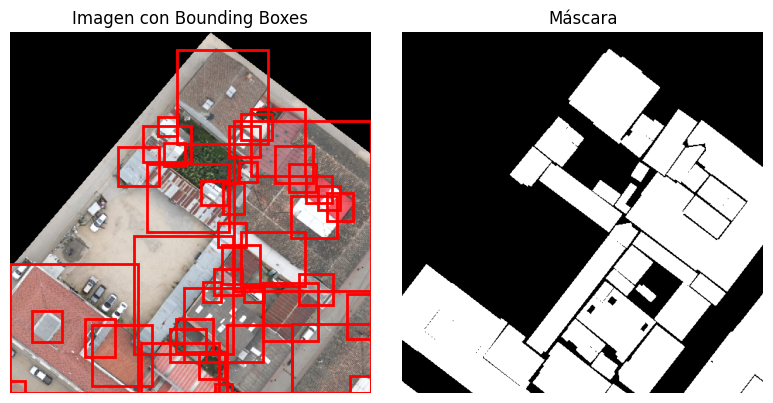

In [9]:
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle

# Rutas a tus archivos
xml_path = "/content/output/annotations/tile_000003.xml"
image_path = "/content/output/images/tile_000003.tif"
mask_path = "/content/output/labels/tile_000003.tif"

# -------------------------------
# 1. Leer y parsear el XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Extraer bounding boxes
boxes = []
for obj in root.findall("object"):
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    boxes.append((xmin, ymin, xmax, ymax))

# -------------------------------
# 2. Leer imagen RGB y máscara
with rasterio.open(image_path) as src_img:
    image = src_img.read([1, 2, 3]).transpose(1, 2, 0)  # HWC

with rasterio.open(mask_path) as src_mask:
    mask = src_mask.read(1)  # Capa única

# -------------------------------
# 3. Visualizar solo imagen con cajas y máscara
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Imagen con bounding boxes
axs[0].imshow(image)
axs[0].set_title("Imagen con Bounding Boxes")
for xmin, ymin, xmax, ymax in boxes:
    rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     edgecolor='red', facecolor='none', linewidth=2)
    axs[0].add_patch(rect)

# Solo la máscara
axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Máscara")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


La función `geoai.train_MaskRCNN_model()` entrena un modelo de segmentación de cubiertas utilizando la arquitectura **Mask R-CNN**. A continuación se describen los parámetros principales:

- **`output_dir`**: carpeta donde se almacenará el modelo entrenado y otros archivos generados.  
  Ejemplo: `output/models/`

- **`num_channels`**: número de bandas o canales en las imágenes de entrada. Para imágenes RGB se usa `3`.

- **`pretrained`**: si es `True`, utiliza un modelo base preentrenado (por ejemplo, en COCO) para transferir conocimiento y acelerar el entrenamiento.

- **`batch_size`**: número de imágenes que se procesan en cada paso de entrenamiento.

- **`num_epochs`**: cantidad de veces que el modelo verá todo el conjunto de entrenamiento. Un número alto generalmente mejora la precisión (con suficiente validación para evitar sobreajuste).

- **`learning_rate`**: tasa de aprendizaje del modelo, que controla cuánto se ajustan los pesos en cada paso de entrenamiento.

- **`val_split`**: proporción del conjunto de datos que se reserva para validación. Por ejemplo, `0.2` significa que el 20% se usará para validar el rendimiento del modelo.

In [10]:
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=3,
    pretrained=True,
    batch_size=4,
    num_epochs=20,
    learning_rate=0.005,
    val_split=0.2,
)

Using device: cuda
Found 90 image files and 90 label files
Training on 72 images, validating on 18 images
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 198MB/s]


Epoch: 1, Batch: 1/18, Loss: 6.6183, Time: 8.64s
Epoch: 1, Batch: 11/18, Loss: 1.2511, Time: 11.12s
Epoch 1/20: Train Loss: 1.9575, Val Loss: inf, Val IoU: 0.3975
Saving best model with IoU: 0.3975
Epoch: 2, Batch: 1/18, Loss: 1.5274, Time: 4.26s
Epoch: 2, Batch: 11/18, Loss: 1.4206, Time: 11.86s
Epoch 2/20: Train Loss: 1.1725, Val Loss: inf, Val IoU: 0.5416
Saving best model with IoU: 0.5416
Epoch: 3, Batch: 1/18, Loss: 0.9165, Time: 3.27s
Epoch: 3, Batch: 11/18, Loss: 0.8873, Time: 12.46s
Epoch 3/20: Train Loss: 0.9462, Val Loss: inf, Val IoU: 0.6376
Saving best model with IoU: 0.6376
Epoch: 4, Batch: 1/18, Loss: 0.7764, Time: 3.43s
Epoch: 4, Batch: 11/18, Loss: 0.8822, Time: 12.60s
Epoch 4/20: Train Loss: 0.8501, Val Loss: inf, Val IoU: 0.6178
Epoch: 5, Batch: 1/18, Loss: 0.7256, Time: 3.82s
Epoch: 5, Batch: 11/18, Loss: 0.7532, Time: 12.17s
Epoch 5/20: Train Loss: 0.7304, Val Loss: inf, Val IoU: 0.6670
Saving best model with IoU: 0.6670
Epoch: 6, Batch: 1/18, Loss: 0.6041, Time: 3.

In [24]:
masks_path = "/content/mask.tif"
model_path = f"/content/output/models/best_model.pth"



La función `geoai.object_detection()` aplica un modelo previamente entrenado **Mask R-CNN** sobre un **raster de prueba** con el objetivo de **detectar y segmentar objetos** geoespaciales.

Este proceso consiste en dividir la imagen en ventanas, realizar inferencia sobre cada una usando el modelo y reconstruir una máscara de predicción completa que representa las áreas detectadas.

In [25]:
geoai.object_detection(
    test_raster_path,
    masks_path,
    model_path,
    window_size=512,
    overlap=256,
    confidence_threshold=0.5,
    batch_size=4,
    num_channels=3,
)

Processing 9 windows with size 512x512 and overlap 256...


16it [00:01,  8.12it/s]

Inference completed in 1.98 seconds
Saved prediction to /content/mask.tif


Ahora, se convierten las máscaras raster resultantes de una predicción en polígonos vectoriales simplificados y alineados ortogonalmente

In [26]:
output_path = "/content/test_predic.geojson"
gdf = geoai.orthogonalize(masks_path, output_path, epsilon=2)

Processing 80 features...


Converting features: 100%|██████████| 80/80 [00:00<00:00, 119.39shape/s]


Saving to /content/test_predic.geojson...
Done!


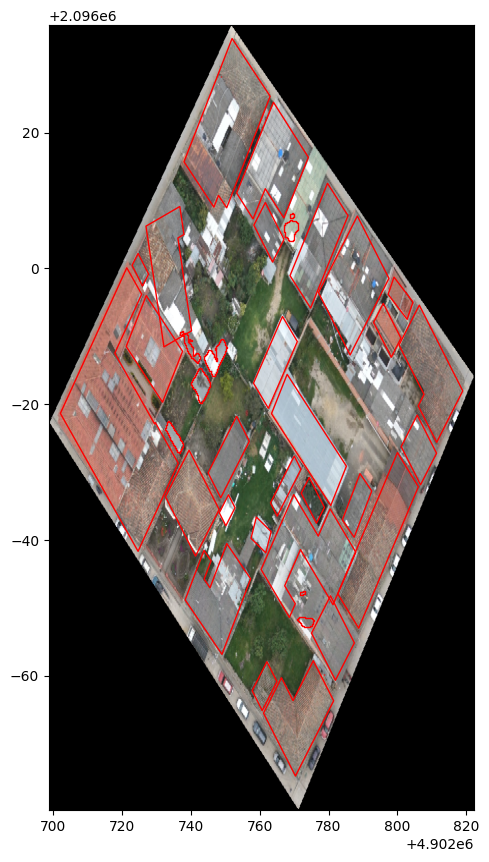

In [32]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt


raster_path = test_raster_path
vector_path = output_path

with rio.open(raster_path) as src:
    fig, ax = plt.subplots(figsize=(5,10))
    show(src, ax=ax)  # Dibuja el TIF (primera banda)

    gdf = gpd.read_file(vector_path)  # GeoJSON
    # Trazo simple del vector encima
    gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)


    plt.tight_layout()
    plt.show()

In [28]:
graficar_mascara_sobre_raster(vector=output_path,raster=test_raster_path)

TypeError: graficar_mascara_sobre_raster() got an unexpected keyword argument 'vector'

Ráster CRS: ESRI:103599
GeoJSON CRS inicial: EPSG:4326
Alineación de CRS: Reproyectando GeoJSON...
GeoJSON CRS final: PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


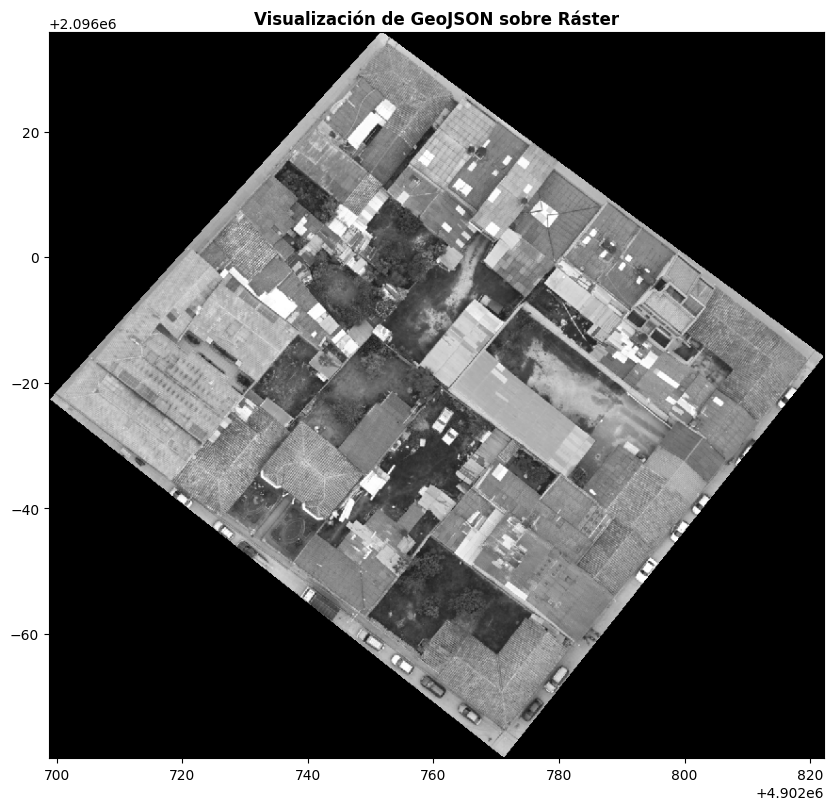


Visualización mostrada.


In [29]:
gdf = gpd.read_file(output_path)

# 2. Leer el Ráster (Datos de Imagen/Grid)
with rasterio.open(test_raster_path) as src:
    raster_data = src.read(1)  # Leer la primera banda
    raster_transform = src.transform
    raster_crs = src.crs

print(f"Ráster CRS: {raster_crs}")
print(f"GeoJSON CRS inicial: {gdf.crs}")

# 3. Asegurar que el GeoJSON esté en el mismo CRS que el ráster
if gdf.crs != raster_crs:
    print("Alineación de CRS: Reproyectando GeoJSON...")
    # Reproyectar el GeoDataFrame para que coincida con el CRS del ráster
    gdf = gdf.to_crs(raster_crs)
    print(f"GeoJSON CRS final: {gdf.crs}")

# --- 4. Visualización y Dibujo ---

# Crear la figura y el eje para el gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Dibujar el Ráster en el eje (como imagen de fondo)
show(
    raster_data,
    transform=raster_transform,
    ax=ax,
    cmap='gray', # Mapa de color
    title="Visualización de GeoJSON sobre Ráster"
)

# Superponer el GeoJSON (como capa vectorial)
gdf.plot(
    ax=ax,
    facecolor='none',  # Sin relleno
    edgecolor='red',
    linewidth=2,
    alpha=0.7,
    zorder=2  # Asegura que se dibuje sobre la capa del ráster
)

ax.set_aspect('equal') # Mantiene la proporción geográfica

# 5. Mostrar el resultado
plt.show()
print("\nVisualización mostrada.")

## Análisis de Resultados o Conclusiones

El uso de GeoAI en este caso de estudio demuestra el potencial de combinar inteligencia artificial con análisis geoespacial para automatizar tareas que tradicionalmente requerían mucho tiempo, como la detección de cubiertas a partir de imágenes satelitales. A través de un flujo estructurado desde la preparación de datos, entrenamiento del modelo con Mask R-CNN, hasta la predicción y postprocesamiento ortogonalizado es posible generar resultados precisos, reutilizables y fácilmente integrables en sistemas de información geográfica (SIG).

Comparado con  SAM (Segment Anything Model), GeoAI requiere mayor preparación inicial, especialmente en la generación de etiquetas de entrenamiento, pero ofrece un control mucho más fino y resultados específicos adaptados a las necesidades del proyecto. Mientras SAM destaca por su capacidad de segmentar rápidamente cualquier objeto sin entrenamiento previo, su naturaleza generalista lo hace menos adecuado cuando se buscan salidas limpias, ortogonales y orientadas a una clase particular como las cubiertas.

## Referencias

*Wu, Q., & Osco, L. (2023). *samgeo: A Python package for segmenting geospatial data with the Segment Anything Model (SAM)*. *Journal of Open Source Software, 8*(89), 5663. https://doi.org/10.21105/joss.05663

*Osco, L. P., Wu, Q., de Lemos, E. L., Gonçalves, W. N., Ramos, A. P. M., Li, J., & Junior, J. M. (2023). *The Segment Anything Model (SAM) for remote sensing applications: From zero to one shot*. *International Journal of Applied Earth Observation and Geoinformation, 124*, 103540. https://doi.org/10.1016/j.jag.2023.103540

*Wu, Q. (2025). *GeoAI: Artificial Intelligence for Geospatial Data* [Software]. Recuperado de https://geoai.gishub.org/
